In [1]:
from obspy import read
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from obspy.signal.trigger import classic_sta_lta, plot_trigger, z_detect, recursive_sta_lta

import os
import plotly.express as px
from geopy import distance
from scipy.fft import fft, ifft, fftfreq
import math
import seaborn as sns


In [2]:
syn_dir = "sw4_test_output" # synthetic 
obs_dir = "obs_test_output" # observation 

In [3]:
station = "BRK"
station2 = "BKS"

network = "BK"
sensor = "HN"
component = "e"

In [4]:
st_syn = read(syn_dir+"//"+network+"."+station+"."+sensor+"."+component)
st_obs = read(obs_dir+"/"+network+"."+station2+"."+sensor+"."+component)

In [5]:
print(st_syn)

1 Trace(s) in Stream:
.BK.BRK..EW | 2018-01-04T10:39:32.690000Z - 2018-01-04T10:42:52.690007Z | 26.5 Hz, 5309 samples


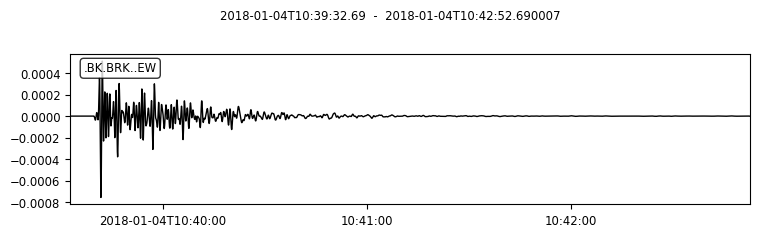

In [6]:
_plot = st_syn.plot()

In [7]:
_plot = st_obs.plot()

## Converting amplitude to cumulative

In [8]:
data = st_obs[0].data # from st stream object to get data in numpy array
time = st_obs[0].times()

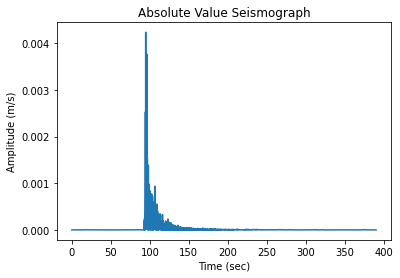

In [10]:
plt.plot(time,abs((data)))
plt.ylabel("Amplitude (m/s)");
plt.xlabel("Time (sec)");
plt.title("Absolute Value Seismograph");
# plt.plot(92.61, 0,'ro') 
# plt.plot(139.32, 0,'ro') 


# plt.xlim(90,140)


### Function that finds the start time of the earthquake based on largest slope

In [66]:
def duration(directory, Point, percentage):
    station = read(directory+"//"+Point)
    
    data = station[0].data
    time = station[0].times()
    
    def smooth(scalars, weight: float):  # Weight between 0 and 1
        last = scalars[0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
            smoothed.append(smoothed_val)                        # Save it
            last = smoothed_val                                  # Anchor the last smoothed value

        return smoothed


    deriv = np.diff(smooth(abs(data), 0.99))

    def finder(y, weight):
        x = time[np.where(deriv==y)]
        return x


    start_time = finder(max(deriv), 0.99)[0]
    
    def percent_of_data(percent):
        max_value = max(np.cumsum(abs(data)))
        normalized_data = np.cumsum(abs(data))/max_value

        y_val = int(percent*len(normalized_data))
        y_percentage = normalized_data[0:y_val]
        val = y_percentage[-1:]

        index = np.where(normalized_data > percent)[0][0]

        end_time = time[0:int(percent*len(time))][-1:]
        return(time[index])

    
    end_time = percent_of_data(percentage)
    duration = end_time - start_time
    station = station[0].stats.station, 
    
    return [start_time, end_time, duration]

duration(obs_dir, "NC.JSP.HN.e", 0.9)

[103.1, 328.78, 225.67999999999998]

array([94.68])

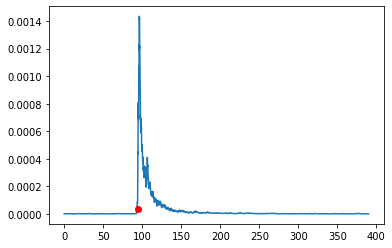

In [12]:
def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed


deriv = np.diff(smooth(abs(data), 0.99))
# plt.plot(time[2:], np.diff(deriv)/0.01)

def finder(y, weight):
    plt.plot(time, smooth(abs(data), weight))
    x = time[np.where(deriv==y)]
    plt.plot(x, y, 'ro')  
    return x



finder(max(deriv), 0.99)



In [13]:
# just doing where the amplitude is greater than 0.001
h = pd.DataFrame({'time': time[1:],'slope':abs(np.diff(abs(data))/0.01), 'acc':abs(np.diff(abs(data))/0.0001) })
h[h["time"]>60]

,time,slope,acc
6000,60.01,7.982010e-07,0.000080
6001,60.02,6.602639e-06,0.000660
6002,60.03,8.060539e-06,0.000806
6003,60.04,7.212839e-06,0.000721
6004,60.05,7.547828e-06,0.000755
...,...,...,...
38994,389.95,2.522199e-07,0.000025
38995,389.96,4.224603e-08,0.000004
38996,389.97,2.394444e-07,0.000024
38997,389.98,5.437926e-08,0.000005


### A function that puts a point at the x-percentile of data

142.17

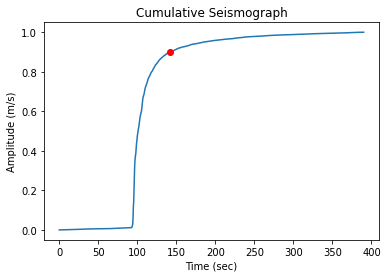

In [12]:
def percent_of_data(percent):
    max_value = max(np.cumsum(abs(data)))
    normalized_data = np.cumsum(abs(data))/max_value
    
    y_val = int(percent*len(normalized_data))
    y_percentage = normalized_data[0:y_val]
    val = y_percentage[-1:]
    
    index = np.where(normalized_data > percent)[0][0]

    
    end_time = time[0:int(percent*len(time))][-1:]
    plt.plot(time, np.cumsum(abs(data))/max_value) #0.9 on the y-axis
    plt.title('Cumulative Seismograph')
    #plt.plot(end_time, val, 'ro') #90th percentile of time data
    plt.plot(time[index], percent, 'ro')

    plt.ylabel("Amplitude (m/s)")
    plt.xlabel("Time (sec)")
    
#     plt.xlim(93,98)

    return(time[index])
    
    
percent_of_data(0.9)

In [15]:
x = np.diff(np.cumsum(abs(data)))/0.0001
max(x)


42.32176

In [16]:
#ending when the amplitude reaches 1
df = pd.DataFrame({'amp': (np.cumsum(abs(data)))[2:], 'time': time[2:], 'slope': x[1:], 'acc': np.diff(x)/0.01})
df[df['acc'] <0]
# print(df.to_string())
# df

,amp,time,slope,acc
33,0.000036,0.35,0.010513,-0.001361
36,0.000039,0.38,0.010584,-0.001128
43,0.000047,0.45,0.010857,-0.002339
46,0.000050,0.48,0.010892,-0.001099
49,0.000053,0.51,0.010974,-0.000600
...,...,...,...,...
38852,1.111804,388.54,0.000000,-0.119209
38854,1.111804,388.56,0.000000,-0.119209
38858,1.111804,388.60,0.000000,-0.119209
38860,1.111804,388.62,0.000000,-0.119209


The data before it visually starts oscillating, oscillates too. This makes it really difficult to pinpoint where we should start and end the timing without using visual cues. I tried bounding where the absolute amplitude is greater than 0.01. Then I started messing around with slopes and second derivatives, but because the data isn't consistently zero before the earthquake it is really hard to quantify. I tried looking at where the second derivative turns negative but some points in the early part also have negative acceleration. I'm not sure at what point we can say the absolute acceleration is large enough though.

In [17]:
# classic_sta_lta - short term vs long term
classic_sta_lta(data, 5, 100)

array([0.        , 0.        , 0.        , ..., 1.86621187, 1.84711385,
       1.8320841 ])

In [18]:
trace = st_obs[0]
df = trace.stats.sampling_rate
df

100.0

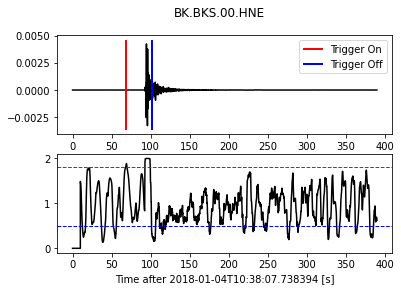

In [19]:
cft = classic_sta_lta(trace.data, int(5 * df), int(10 * df))
plot_trigger(trace, cft, 1.8, 0.5)

## Creating a Mass Dataframe

In [20]:
directory = "./sw4_test_output/"
obs_directory = "./obs_test_output/"

# station location data
locations = pd.read_csv('sw4_station.txt', delimiter = ",")


In [21]:
def times(inputdirectory, percentage):    
    def create_df(directory, bandpass=False, bp_range=[0, 1]):
        """
        Creates pandas DataFrame from seismic data.

        Args:
            directory: The directory (string) where seismic data is located (containing .e, ,n. .u files)

        Returns:
            pandas DataFrame

        Raises:
            AssertionError: If there is an issue with the data files
        """
        # cleaning and putting all the sw4 seismic data into a DataFrame
        # .BH is removed (they are duplicate sensors)
        file_list = os.listdir(directory)
        file_list.sort()
        file_list = [x for x in file_list if "sw4img" not in x and ".dat" not in x and "BH" not in x and ".xml" not in x and ".sacpz" not in x]
        assert((len(file_list) / 3) - int(len(file_list) / 3) == 0)
        df = pd.DataFrame(data=file_list)
        df.columns = ['Point']

        # peak and duration data for each point
        absolute_peaks = []
        durations = []
        amplitudes = []
        times = []
        deltas = []
        for i in range(len(file_list)):
            st = read(directory+file_list[i])
            tr = st[0]
            if bandpass:
                tr.filter('bandpass', freqmin=bp_range[0], freqmax=bp_range[1], corners=2, zerophase=True)
            abs_data = abs(tr.data)
            time = tr.times()
            threshold = max(abs_data) * 0.1
            start = np.argmax(abs_data>threshold)
            data_flipped = np.flip(abs_data)
            end = len(abs_data) - np.argmax(data_flipped>threshold) - 1
            duration = time[end] - time[start]
            absolute_peaks.append(abs(max(tr.data, key=abs)))
            durations.append(duration)
            amplitudes.append(tr.data)
            times.append(tr.times())
            deltas.append(tr.stats['delta'])
            # test single point
            # set name of data point to name

            name = "" #"BK.BRK.HN.u"
            if file_list[i] == name:
                print('peak: ', abs(max(tr.data, key=abs)))
                print('duration: ', [time[start], time[end]])
                plt.plot(time, tr.data)
                plt.axvline(x=time[start], color='r')
                plt.axvline(x=time[end], color='r')   


        # full dataframe
        df["Station"] = [x[:-5] for x in df["Point"]]
        df["Amplitudes"] = amplitudes
        df["Times"] = times
        df["Absolute Peak"] = absolute_peaks
        df["Duration"] = durations
        df["Delta"] = deltas
        df_with_locations = pd.merge(df, locations, left_on='Station', right_on='net.sta')
        df_with_locations = df_with_locations.drop(columns=['net.sta'])
        source = (37.86119, -122.24233)
        df_with_locations['Distance (miles)'] = df_with_locations.apply(lambda row: distance.distance((row.lat, row.lon), source).miles, axis=1)
        return df_with_locations
    
    table = create_df(inputdirectory)
    station = table[['Point', 'Station', 'lat', 'lon', 'Absolute Peak']]
    station= station.copy()
    durationStuff = station["Point"]
    
    durationStuff = durationStuff.map(lambda x : duration(inputdirectory, x, percentage))
    station['durationStuff'] = durationStuff
    station[['Start Time', 'End Time', 'Duration']] = pd.DataFrame(station.durationStuff.tolist(), index = station.index)
    return station.drop(columns = ["durationStuff"])

In [22]:
synthetic = times(directory, 0.9)
synthetic

,Point,Station,lat,lon,Absolute Peak,Start Time,End Time,Duration
0,BK.BDM.HN.e,BK.BDM,37.953970,-121.86554,0.000380,18.311983,82.479280,64.167297
1,BK.BDM.HN.n,BK.BDM,37.953970,-121.86554,0.000315,18.123588,81.085158,62.961570
2,BK.BDM.HN.u,BK.BDM,37.953970,-121.86554,0.000358,12.057272,74.189905,62.132632
3,BK.BKS.HN.e,BK.BKS,37.876220,-122.23558,0.001960,10.060287,77.731729,67.671442
4,BK.BKS.HN.n,BK.BKS,37.876220,-122.23558,0.001214,10.738508,78.296913,67.558405
...,...,...,...,...,...,...,...,...
952,NP.ADS2.HN.n,NP.ADS2,38.774460,-122.69974,0.000211,37.377545,86.096461,48.718917
953,NP.ADS2.HN.u,NP.ADS2,38.774460,-122.69974,0.000110,23.963829,85.342882,61.379053
954,NP.PLA.HN.e,NP.PLA,37.798672,-121.46315,0.000247,45.365488,107.460441,62.094953
955,NP.PLA.HN.n,NP.PLA,37.798672,-121.46315,0.000639,28.183874,90.542581,62.358706


In [23]:
observed = times(obs_directory, 0.9)
observed

,Point,Station,lat,lon,Absolute Peak,Start Time,End Time,Duration
0,BK.BDM.HN.e,BK.BDM,37.953970,-121.86554,0.001021,105.360,192.780,87.420
1,BK.BDM.HN.n,BK.BDM,37.953970,-121.86554,0.001588,102.740,194.320,91.580
2,BK.BDM.HN.u,BK.BDM,37.953970,-121.86554,0.000720,103.290,178.880,75.590
3,BK.BKS.HN.e,BK.BKS,37.876220,-122.23558,0.004232,94.680,142.170,47.490
4,BK.BKS.HN.n,BK.BKS,37.876220,-122.23558,0.002665,94.820,151.320,56.500
...,...,...,...,...,...,...,...,...
890,NP.ADS2.HN.n,NP.ADS2,38.774460,-122.69974,0.000081,59.340,202.150,142.810
891,NP.ADS2.HN.u,NP.ADS2,38.774460,-122.69974,0.000112,58.545,204.865,146.320
892,NP.PLA.HN.e,NP.PLA,37.798672,-121.46315,0.000886,120.935,209.435,88.500
893,NP.PLA.HN.n,NP.PLA,37.798672,-121.46315,0.000887,116.390,214.120,97.730


## Puts into Final Form DataFrame with Mean and Direction Specific Info

In [24]:
def FinalForm(df):
    df['Station'] = [x[:-2] for x in df["Point"]]
    df['Direction'] = [x[-1:] for x in df["Point"]]
    maxAmp = df.groupby("Station")["Absolute Peak"].max()
    means = df.groupby("Station")["lat", "lon", "Duration", "End Time", "Start Time"].mean()
    pivoted = df[["Point", "Station", "Direction", "Duration", "End Time", "Start Time"]].pivot_table(index = "Station", columns = "Direction")
    pivoted.columns = [' '.join(col).strip() for col in pivoted.columns.values]
    final = means.merge(pivoted, on = 'Station')
    final.columns= [f'Mean {i}' if i in ["Duration", "End Time", "Start Time"] else f'{i}' for i in final.columns]
    final["distance"] = ((110*(final['lat'] - 37.855))**2 + (110*(final['lon'] + 122.257))**2)**0.5
    final.insert(2, "Max Peak", maxAmp)
    return final

In [25]:
FinalForm(synthetic)

/var/folders/3v/m28vhrtx0tjc65zchk0jbdfm0000gn/T/ipykernel_17987/1666268597.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = df.groupby("Station")["lat", "lon", "Duration", "End Time", "Start Time"].mean()
/var/folders/3v/m28vhrtx0tjc65zchk0jbdfm0000gn/T/ipykernel_17987/1666268597.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivoted = df[["Point", "Station", "Direction", "Duration", "End Time", "Start Time"]].pivot_table(index = "Station", columns = "Direction")


,lat,lon,Max Peak,Mean Duration,Mean End Time,Mean Start Time,Duration e,Duration n,Duration u,End Time e,End Time n,End Time u,Start Time e,Start Time n,Start Time u,distance
Station,,,,,,,,,,,,,,,,
BK.BDM.HN,37.953970,-121.865540,0.000380,63.087166,79.251447,16.164281,64.167297,62.961570,62.132632,82.479280,81.085158,74.189905,18.311983,18.123588,12.057272,44.415487
BK.BKS.HN,37.876220,-122.235580,0.001960,71.929166,82.504399,10.575233,67.671442,67.558405,80.557652,77.731729,78.296913,91.484555,10.060287,10.738508,10.926903,3.316650
BK.BL67.HN,37.874920,-122.243180,0.001485,71.313743,81.374030,10.060287,67.935195,69.065564,76.940470,77.807087,79.540319,86.774683,9.871892,10.474755,9.834213,2.666902
BK.BL88.HN,37.877150,-122.254290,0.001141,66.340118,75.345393,9.005275,61.981916,61.981916,75.056521,71.100229,70.987192,83.948760,9.118312,9.005275,8.892238,2.454668
BK.BRK.HN,37.873520,-122.260990,0.001371,57.485559,66.377797,8.892238,53.730221,55.237380,63.489075,62.735496,64.129618,72.268277,9.005275,8.892238,8.779202,2.083943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP.1862.HN,37.299500,-122.084900,0.000303,53.554385,73.700078,20.145693,56.518465,51.431803,52.712888,75.584027,76.036175,69.480033,19.065562,24.604372,16.767145,63.970335
NP.1863.HN,37.666656,-121.857147,0.000786,77.643811,96.081390,18.437579,76.639038,74.039189,82.253206,96.872649,93.443862,97.927660,20.233610,19.404673,15.674454,48.618990
NP.1865.HN,36.883110,-121.390800,0.000202,76.011055,119.530273,43.519218,80.670689,69.065564,78.296913,125.094202,127.430299,106.066319,44.423513,58.364735,27.769406,143.206001


In [26]:
FinalForm(observed)
#Weird Issue: some of the points in the obsberved df dont end in n,e, or u. Some end in 1,2, or 3. Any thoughts?

/var/folders/3v/m28vhrtx0tjc65zchk0jbdfm0000gn/T/ipykernel_17987/1666268597.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = df.groupby("Station")["lat", "lon", "Duration", "End Time", "Start Time"].mean()
/var/folders/3v/m28vhrtx0tjc65zchk0jbdfm0000gn/T/ipykernel_17987/1666268597.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivoted = df[["Point", "Station", "Direction", "Duration", "End Time", "Start Time"]].pivot_table(index = "Station", columns = "Direction")


,lat,lon,Max Peak,Mean Duration,Mean End Time,Mean Start Time,Duration 1,Duration 2,Duration 3,Duration e,...,End Time e,End Time n,End Time u,Start Time 1,Start Time 2,Start Time 3,Start Time e,Start Time n,Start Time u,distance
Station,,,,,,,,,,,,,,,,,,,,,
BK.BDM.HN,37.953970,-121.865540,0.001588,84.863333,188.660000,103.796667,NaN,NaN,NaN,87.420,...,192.780,194.32,178.880,NaN,NaN,NaN,105.360,102.740,103.290,44.415487
BK.BKS.HN,37.876220,-122.235580,0.004232,52.626667,147.833333,95.206667,NaN,NaN,NaN,47.490,...,142.170,151.32,150.010,NaN,NaN,NaN,94.680,94.820,96.120,3.316650
BK.BL67.HN,37.874920,-122.243180,0.010264,44.113333,138.920000,94.806667,NaN,NaN,NaN,40.080,...,134.650,135.28,146.830,NaN,NaN,NaN,94.570,94.560,95.290,2.666902
BK.BL88.HN,37.877150,-122.254290,0.012936,69.313333,164.200000,94.886667,NaN,NaN,NaN,55.980,...,150.580,154.43,187.590,NaN,NaN,NaN,94.600,94.540,95.520,2.454668
BK.BRK.HN,37.873520,-122.260990,0.005653,63.266667,157.553333,94.286667,NaN,NaN,NaN,46.850,...,141.170,148.75,182.740,NaN,NaN,NaN,94.320,94.110,94.430,2.083943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP.1861.HN,37.792070,-122.263760,0.020534,47.680000,89.746667,42.066667,NaN,NaN,NaN,46.375,...,89.220,91.80,88.220,NaN,NaN,NaN,42.845,42.755,40.600,6.962125
NP.1862.HN,37.299500,-122.084900,0.003618,88.838333,140.231667,51.393333,NaN,NaN,NaN,54.205,...,105.215,149.36,166.120,NaN,NaN,NaN,51.010,52.310,50.860,63.970335
NP.1863.HN,37.666656,-121.857147,0.002186,141.696667,245.983333,104.286667,NaN,NaN,NaN,102.980,...,208.470,196.41,333.070,NaN,NaN,NaN,105.490,108.510,98.860,48.618990


/var/folders/3v/m28vhrtx0tjc65zchk0jbdfm0000gn/T/ipykernel_17987/1666268597.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = df.groupby("Station")["lat", "lon", "Duration", "End Time", "Start Time"].mean()
/var/folders/3v/m28vhrtx0tjc65zchk0jbdfm0000gn/T/ipykernel_17987/1666268597.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivoted = df[["Point", "Station", "Direction", "Duration", "End Time", "Start Time"]].pivot_table(index = "Station", columns = "Direction")
/var/folders/3v/m28vhrtx0tjc65zchk0jbdfm0000gn/T/ipykernel_17987/1666268597.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = df.groupby("Station")["l

(0.0, 268.35200000000003)

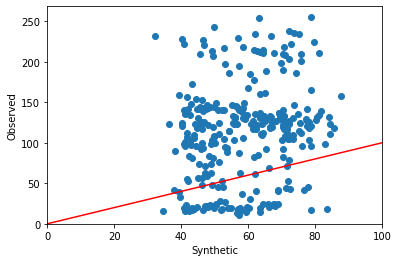

In [63]:
#scatter plot of mean durations of syn vs obs

synMeanDuration = FinalForm(synthetic)[["Mean Duration", 'distance']]
obsMeanDuration = FinalForm(observed)[["Mean Duration"]]

p = synMeanDuration.merge(obsMeanDuration, on = "Station")

plt.scatter(p["Mean Duration_x"], p["Mean Duration_y"])
plt.plot([0,250], [0, 250], 'k-', color = 'r')
plt.xlabel("Synthetic")
plt.ylabel("Observed")
plt.xlim(0,100)
plt.ylim(0,)

# p['duration difference'] = p["Mean Duration_x"] -  p["Mean Duration_y"]
# p.sort_values('distance')

# plt.scatter(p['distance'], p['duration difference'])

In [42]:
p.sort_values("duration difference")

,Mean Duration_x,distance,Mean Duration_y,duration difference
Station,,,,
NC.JSP.HN,32.202965,39.999908,231.726667,-199.523701
NC.NTAC.HN,49.861846,38.100255,242.560000,-192.698154
NC.CMOB.HN,63.149965,50.210978,254.190000,-191.040035
NC.C055.HN,40.303945,27.063673,227.646667,-187.342721
NC.JGR.HN,40.869130,43.356711,222.510000,-181.640870
...,...,...,...,...
CE.58340.HN,57.422760,29.541202,11.358333,46.064427
CE.58626.HN,67.960314,69.180074,21.785000,46.175314
CE.57218.HN,63.702590,45.919700,14.126667,49.575923


In [70]:
st_syn2 = read(syn_dir+"//"+"NC"+"."+"JSP"+"."+'HN'+"."+'e')
st_obs2 = read(obs_dir+"//"+"NC"+"."+"JSP"+"."+'HN'+"."+'e')

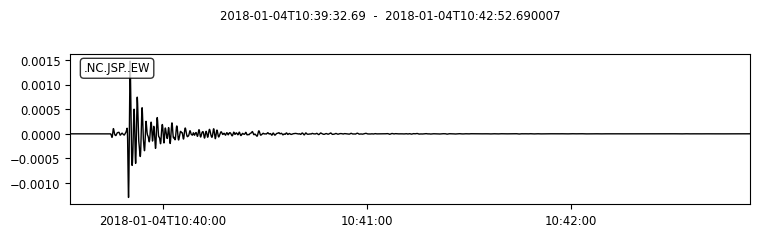

In [86]:
_s = st_syn2.plot()

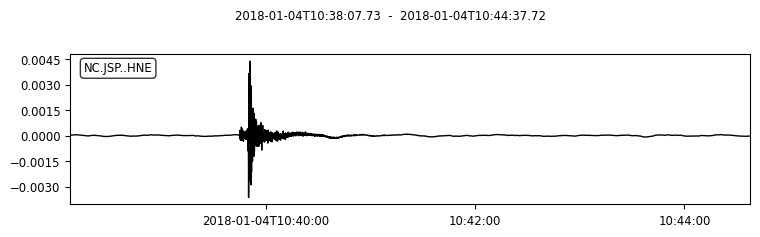

In [91]:
o = st_obs2.plot() # it just doesnt look like zero as the synthtic one does
_o

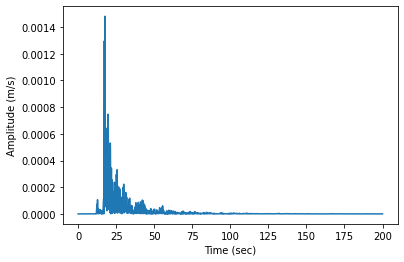

In [58]:
data = st_syn2[0].data # from st stream object to get data in numpy array
time = st_syn2[0].times()

plt.plot(time,abs((data)))
plt.ylabel("Amplitude (m/s)");
plt.xlabel("Time (sec)");
# plt.plot(92.61, 0,'ro') 
# plt.plot(139.32, 0,'ro') 


# plt.xlim(120,160)


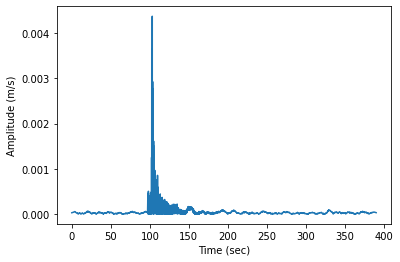

In [59]:
data = st_obs2[0].data # from st stream object to get data in numpy array
time = st_obs2[0].times()

plt.plot(time,abs((data)))
plt.ylabel("Amplitude (m/s)");
plt.xlabel("Time (sec)");
# plt.plot(92.61, 0,'ro') 
# plt.plot(139.32, 0,'ro') 


# plt.xlim(120,160)

